In [1]:
# !pip install --upgrade scipy

In [2]:
!pip install sympy

Looking in indexes: https://artifactory.airbus.corp/artifactory/api/pypi/r-airbus-pypi-virtual/simple


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import sympy as sp

2024-05-06 18:44:29.315836: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 18:44:29.340960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 18:44:29.340982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 18:44:29.341503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 18:44:29.345618: I tensorflow/core/platform/cpu_feature_guar

In [4]:
# Déclaration des symboles
x, y, k_x, k_y, omega = sp.symbols('x y k_x k_y omega')

# Définition de la fonction phi
phi = sp.Function('phi')(x, y)

# Calcul des dérivées partielles secondes
d2phi_dx2 = phi.diff(x, x)
d2phi_dy2 = phi.diff(y, y)

# Calcul du laplacien
laplacian_phi = d2phi_dx2 + d2phi_dy2

# Définition de l'équation de Helmholtz
equation = sp.Eq(-laplacian_phi - omega**2 * phi, 0)

# Affichage de l'équation
display(equation)

Eq(-omega**2*phi(x, y) - Derivative(phi(x, y), (x, 2)) - Derivative(phi(x, y), (y, 2)), 0)

In [5]:
# Génération des valeurs



def generate_k(lambda_value):
    # Générer kx et ky aléatoirement
    k_magnitude = 2 * np.pi / lambda_value
    theta = np.random.uniform(0, 2 * np.pi)  # Angle aléatoire entre 0 et 2pi
    kx = k_magnitude * np.cos(theta)
    ky = k_magnitude * np.sin(theta)
    return kx, ky

lambda_val = 1
omega = 2*np.pi/lambda_val
k_x, k_y = generate_k(lambda_val)

print(f"k_x: {k_x}, k_y: {k_y}")



k_x: 4.340195058308399, k_y: -4.54325042895423


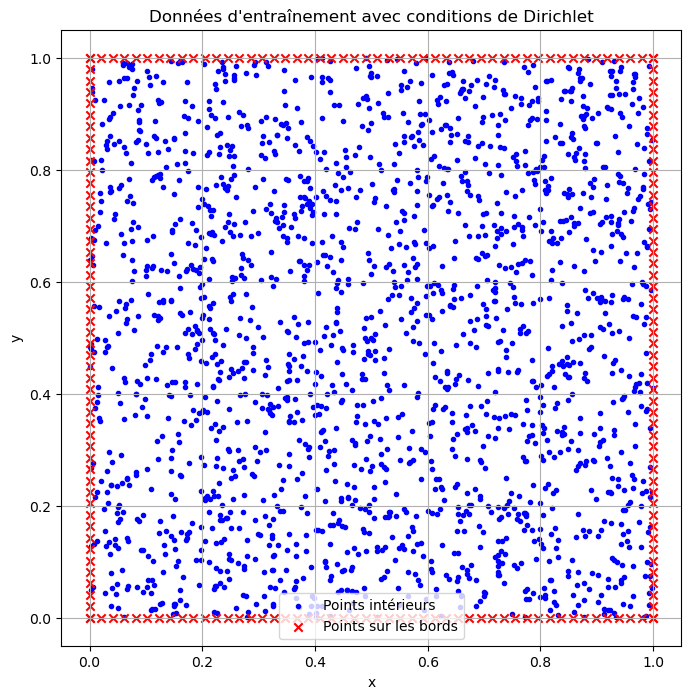

In [6]:
# Définition des données d'entraînement
n_interior = 2000  # Nombre de points à l'intérieur du domaine
n_boundary = 50  # Nombre de points sur les bords

# Points à l'intérieur du domaine
x_interior = np.random.uniform(low=0, high=1, size=(n_interior, 2))

# Points sur les bords
x_boundary = np.vstack([
    np.linspace(0, 1, n_boundary),  # Bord inférieur (y=0)
    np.zeros(n_boundary),
]).T
x_boundary = np.vstack([x_boundary, np.vstack([
    np.linspace(0, 1, n_boundary),  # Bord supérieur (y=1)
    np.ones(n_boundary),
]).T])
x_boundary = np.vstack([x_boundary, np.vstack([
    np.zeros(n_boundary),  # Bord gauche (x=0)
    np.linspace(0, 1, n_boundary),
]).T])
x_boundary = np.vstack([x_boundary, np.vstack([
    np.ones(n_boundary),  # Bord droit (x=1)
    np.linspace(0, 1, n_boundary),
]).T])

# Valeurs de la solution sur les bords (conditions de Dirichlet)
# u_boundary = np.exp(-1j * (k_x * x_boundary[:, 0] + k_y * x_boundary[:, 1]))  # Fonction définie par la condition

u_boundary_real = np.cos(k_x * x_boundary[:, 0] + k_y * x_boundary[:, 1])
u_boundary_imag = -np.sin(k_x * x_boundary[:, 0] + k_y * x_boundary[:, 1])

u_boundary = np.stack((u_boundary_real, u_boundary_imag), axis=-1)

# Affichage des données d'entraînement
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(x_interior[:, 0], x_interior[:, 1], c='b', marker='.', label='Points intérieurs')
plt.scatter(x_boundary[:, 0], x_boundary[:, 1], c='r', marker='x', label='Points sur les bords')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Données d\'entraînement avec conditions de Dirichlet')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def compute_derivatives(x, y, u):
    dudx, dudy = tf.gradients(u, [x, y])
    dudxx = tf.gradients(dudx, x)[0]
    dudyy = tf.gradients(dudy, y)[0]
    return dudxx, dudyy

In [8]:
u_boundary.shape

(200, 2)

In [130]:
def custom_loss(x_interior_tf, x_boundary_tf, u_boundary, omega,preds):
    u_pred = preds[:,:2]
    laplacian_u_pred_x_reel = preds[:,2]
    laplacian_u_pred_y_reel = preds[:,3]
    laplacian_u_pred_x_im = preds[:,4]
    laplacian_u_pred_y_im  = preds[:,5]
    laplacian_u_pred_reel = laplacian_u_pred_x_reel + laplacian_u_pred_y_reel
    laplacian_u_pred_im = laplacian_u_pred_x_im + laplacian_u_pred_y_im
    residue_interior = (laplacian_u_pred_reel + omega**2 * u_pred[:,0])**2 + (laplacian_u_pred_im + omega**2 * u_pred[:, 1])**2
    loss_interior = tf.reduce_mean(residue_interior)

        

    return loss_interior 

In [131]:
from typing import Tuple, Callable, List, Union
from tensorflow.keras.layers import Input, Dense, Concatenate

In [132]:
class Model(tf.keras.Model):
    def __init__(self, layer_widths: List[int]=[64, 64, 64], activation: Union[str, Callable]='tanh', **kwargs):
        super().__init__(**kwargs)
        self.layer_sequence = [tf.keras.layers.Dense(width, activation=activation) for width in layer_widths]
        self.layer_sequence.append(tf.keras.layers.Dense(2))

    def call(self, xy, training=None, mask=None):
        x, y = xy[:, :1], xy[:, 1:]

        u = Concatenate()([x, y])
        for layer in self.layer_sequence:
            u = layer(u)
        laplacian_u_pred_x_reel, laplacian_u_pred_y_reel = compute_derivatives(x, y, u[:,0])
        laplacian_u_pred_x_im, laplacian_u_pred_y_im = compute_derivatives(x, y, u[:,1])
        return tf.concat([u, laplacian_u_pred_x_reel,laplacian_u_pred_y_reel,laplacian_u_pred_x_im,laplacian_u_pred_y_im], axis=-1)


In [133]:
model = Model(layer_widths = [50]*2)

In [134]:
model.compile(optimizer='adam', loss=lambda y_true, y_pred: custom_loss( x_interior, x_boundary, u_boundary, omega,y_pred))

In [135]:
history = model.fit(
    tf.concat([x_interior, x_boundary],axis=0),
    tf.concat([np.zeros((n_interior, 2)), u_boundary],axis=0),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100


2024-05-06 19:04:53.586536: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: Graph execution error:

Detected at node lambda/sub defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_94566/955315740.py", line 1, in <module>

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__

  File "/tmp_secteur/ahebbal/miniconda3/envs/tfdgp/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call

  File "/tmp/ipykernel_94566/1208259028.py", line 1, in 

  File "/tmp/ipykernel_94566/1208259028.py", line 1, in 

  File "/tmp/ipykernel_94566/3633722813.py", line 18, in custom_loss

required broadcastable shapes
	 [[{{node lambda/sub}}]] [Op:__inference_train_function_109144]

In [ ]:
# Tracer la loss en fonction du nombre d'époques
plt.plot(history.history['loss'])
plt.title('Evolution de la loss pendant l\'entraînement')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Loss')
plt.show()


313/313 [==============================] - 0s 757us/step


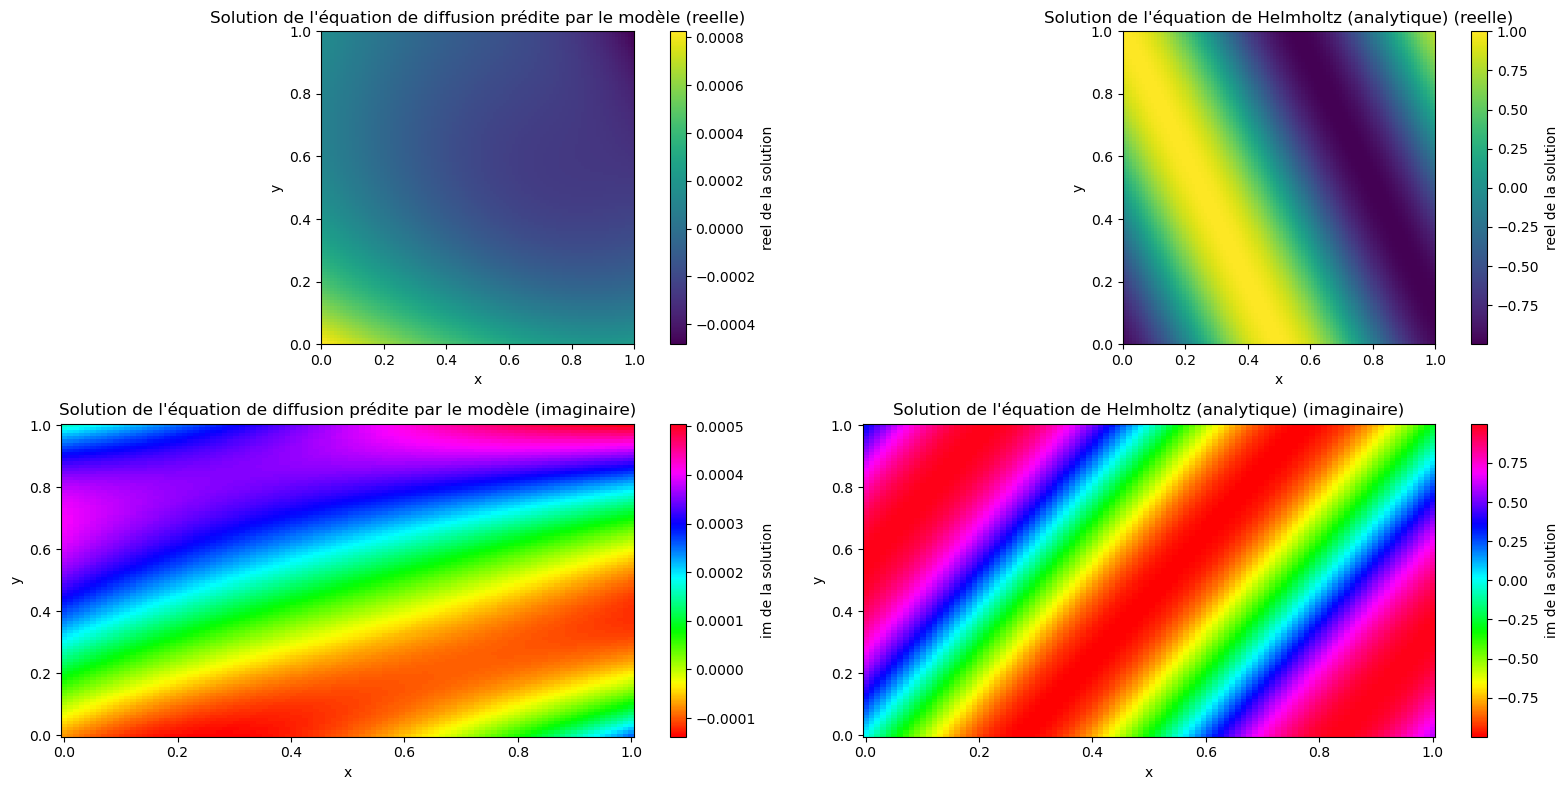

In [216]:
# Générer une grille de points à l'intérieur du domaine
n_points = 100
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, n_points), np.linspace(0, 1, n_points))
points_grid = np.vstack([x_grid.ravel(), y_grid.ravel()]).T

# Prédire les valeurs de la solution sur la grille
solution_predicted = model.predict(points_grid)[:,0].reshape(n_points, n_points) + 1j*model.predict(points_grid)[:,1].reshape(n_points, n_points)

# Calculer les valeurs de la solution analytique sur la grille de points
analytical_solution_values = np.exp(-1j * (k_x * points_grid[:, 0] + k_y * points_grid[:, 1]))

# Tracer la solution prédite par le modèle et la solution analytique
plt.figure(figsize=(16, 8))

# Solution prédite par le modèle réelle
plt.subplot(2, 2, 1)
plt.imshow(np.real(solution_predicted), cmap='viridis', extent=[0, 1, 0, 1])
plt.colorbar(label='reel de la solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de l\'équation de diffusion prédite par le modèle (reelle)')

# Solution analytique réelle
plt.subplot(2, 2, 2)
plt.imshow(np.real(analytical_solution_values).reshape(n_points, n_points), cmap='viridis', extent=[0, 1, 0, 1])
plt.colorbar(label='reel de la solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de l\'équation de Helmholtz (analytique) (reelle)')

# Solution prédite par le modèle imaginaire
plt.subplot(2, 2, 3)
plt.pcolormesh(x_grid, y_grid, np.imag(solution_predicted), cmap='hsv', shading='auto')
plt.colorbar(label='im de la solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de l\'équation de diffusion prédite par le modèle (imaginaire)')

# Solution analytique imaginaire
plt.subplot(2, 2, 4)
plt.pcolormesh(x_grid, y_grid, np.imag(analytical_solution_values).reshape(n_points, n_points), cmap='hsv', shading='auto')
plt.colorbar(label='im de la solution')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution de l\'équation de Helmholtz (analytique) (imaginaire)')

plt.tight_layout()
plt.show()
